Team Rolling Averages - Expected Score

- Expected Score For v Against
- Score For v Against
- Expected Score Difference v Score Difference

In [1]:
import pandas as pd
from mplfooty.pitch import Pitch
import matplotlib.patheffects as pe

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 100
pd.options.display.max_columns = 999

Data

In [2]:
df_shots = pd.read_csv("/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/data/shot_chains_xScore.csv", low_memory=False)
df_shots.head()

,Chain_Number,Initial_State,Final_State,Order,Quarter,Quarter_Duration_Chain_Start,Quarter_Duration,Team_Chain,Team,Player,AFL_API_Player_ID,Description,x,y,Disposal,Shot_At_Goal,Behind_Detail,Venue_Width,Venue_Length,Home_Team,Away_Team,Home_Team_Direction_Q1,Match_ID,Round_ID,Year,Goal,Behind,Miss,Score,Home_Score,Away_Score,Home_Current_Score,Away_Current_Score,Current_Margin,Event_Type0,Event_Type1,Event_Type2,Event_Type3,x0,x1,x2,x3,y0,y1,y2,y3,Quarter_Duration0,Quarter_Duration1,Quarter_Duration2,Quarter_Duration3,Chain_Duration,Time_Since_Last_Action,Distance_Since_Last_Action,Distance_to_Right_Goal_x,Distance_to_Middle_y,Distance_to_Middle_Goal,Angle_to_Middle_Goal,Angle_to_Middle_Goal_degrees,Visible_Goal_Angle,Visible_Goal_Angle_degrees,Visible_Behind_Angle,Visible_Behind_Angle_degrees,Squared_Distance_to_Middle_Goal,Log_Distance_to_Middle_Goal,Set_Shot,random100,ModellingFilter,ballUp,centreBounce,kickIn,possGain,throwIn,xGoals,xBehinds,xMiss,xGoals_normalised,xBehinds_normalised,xMiss_normalised,xScore
0,1,centreBounce,goal,11.0,1,13,39.0,Brisbane Lions,Brisbane Lions,Zac Bailey,Zac_Bailey,Kick,26.0,-21.0,effective,True,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021,1,0,0,6,6,0,0.0,0.0,0.0,Kick,Handball Received,Handball,Gather from Opposition,26.0,18.0,11.0,6.0,-21.0,-23.0,-26.0,-27.0,39.0,38.0,37.0,36.0,26.0,1.0,8.246211,52.0,21.0,56.080300,0.383818,21.991130,0.106164,6.082774,0.327040,18.737997,2704.0,3.951244,False,6,True,0,1,0,0,0,0.377382,0.423225,0.206330,0.374782,0.420309,0.204908,2.669003
1,6,possGain,goal,61.0,1,149,168.0,Brisbane Lions,Brisbane Lions,Zac Bailey,Zac_Bailey,Kick,35.0,19.0,effective,True,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021,1,0,0,6,6,0,6.0,0.0,6.0,Kick,Handball Received,Handball,Loose Ball Get,35.0,28.0,25.0,22.0,19.0,19.0,26.0,29.0,168.0,167.0,165.0,165.0,19.0,1.0,7.000000,43.0,19.0,47.010637,0.416065,23.838740,0.125105,7.167963,0.389831,22.335680,1849.0,3.761200,False,53,True,0,0,0,1,0,0.309688,0.365276,0.175964,0.363941,0.429268,0.206791,2.612916
2,10,possGain,goal,110.0,1,285,306.0,Brisbane Lions,Brisbane Lions,Joe Daniher,Joe_Daniher,Kick,50.0,24.0,effective,True,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021,1,0,0,6,6,0,12.0,0.0,12.0,Kick,Gather,Kick Inside 50 Result,Kick Into F50,50.0,50.0,50.0,-8.0,24.0,28.0,28.0,44.0,306.0,305.0,304.0,303.0,21.0,1.0,4.000000,28.0,24.0,36.878178,0.708626,40.601295,0.132764,7.606837,0.424028,24.295030,784.0,3.332205,False,83,False,0,0,0,1,0,0.362279,0.450421,0.230483,0.347282,0.431775,0.220943,2.515469
3,17,kickIn,behind,183.0,1,520,582.0,Sydney,Sydney,Isaac Heeney,Isaac_Heeney,Kick,46.0,-41.0,ineffective,True,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021,0,1,0,1,0,1,18.0,0.0,18.0,Kick,Mark On Lead,Kick Inside 50 Result,Kick Into F50,46.0,49.0,49.0,19.0,-41.0,-35.0,-35.0,-49.0,582.0,550.0,548.0,548.0,62.0,32.0,6.708204,32.0,41.0,52.009614,0.908067,52.028396,0.075999,4.354442,0.235146,13.472898,1024.0,3.465736,True,4,True,0,0,1,0,0,0.238486,0.395111,0.376768,0.236039,0.391057,0.372903,1.807294
4,21,possGain,goal,222.0,1,653,666.0,Sydney,Sydney,Logan McDonald,Logan_McDonald,Kick,34.0,15.0,effective,True,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021,1,0,0,6,0,6,18.0,1.0,17.0,Kick,Handball Received,Handball,Handball Received,34.0,19.0,10.0,7.0,15.0,17.0,20.0,20.0,666.0,664.0,662.0,662.0,13.0,2.0,15.132746,44.0,15.0,46.486557,0.328553,18.824710,0.130930,7.501763,0.408345,23.396432,1936.0,3.784190,False,39,True,0,0,0,1,0,0.490217,0.479007,0.195058,0.421047,0.411419,0.167535,2.937698


In [140]:
set(df_shots['Team'].unique())

{'Adelaide',
 'Brisbane Lions',
 'Carlton',
 'Collingwood',
 'Essendon',
 'Fremantle',
 'Geelong',
 'Gold Coast',
 'Greater Western Sydney',
 'Hawthorn',
 'Melbourne',
 'North Melbourne',
 'Port Adelaide',
 'Richmond',
 'St Kilda',
 'Sydney',
 'West Coast',
 'Western Bulldogs'}

In [141]:
set(df_shots[df_shots['Round_ID'] == "202101"]['Team'].unique())

{'Brisbane Lions',
 'Carlton',
 'Collingwood',
 'Essendon',
 'Fremantle',
 'Gold Coast',
 'Greater Western Sydney',
 'Hawthorn',
 'Melbourne',
 'North Melbourne',
 'Port Adelaide',
 'Richmond',
 'St Kilda',
 'Sydney',
 'West Coast',
 'Western Bulldogs'}

Rolling Averages

In [126]:
team = "Geelong"

In [169]:
def get_rolling_data(team, window, data = df_shots):
    
    df_team = data[data['Team'] == team]
    df_team_for = df_team.groupby('Round_ID')['Score', 'xScore'].sum().rename(columns={'Score':"For",
                                                                                    "xScore":"xFor"})
    df_opp = data[((data['Home_Team'] == team) | (data['Away_Team'] == team)) & (data['Team'] != team)]
    df_team_agg = df_opp.groupby('Round_ID')['Score', 'xScore'].sum().rename(columns={'Score':"Against",
                                                                                    "xScore":"xAgainst"})

    df_expected = pd.merge(df_team_for, df_team_agg, left_index=True, right_index=True)
    df_expected['rollingFor'] = df_expected['For'].rolling(window=window, min_periods=0).mean()
    df_expected['rollingxFor'] = df_expected['xFor'].rolling(window=window, min_periods=0).mean()
    df_expected['rollingAgainst'] = df_expected['Against'].rolling(window=window, min_periods=0).mean()
    df_expected['rollingxAgainst'] = df_expected['xAgainst'].rolling(window=window, min_periods=0).mean()

    df_expected['rollingDiff'] = df_expected['rollingFor'] - df_expected['rollingAgainst']
    df_expected['rollingxDiff'] = df_expected['rollingxFor'] - df_expected['rollingxAgainst']
    
    # Filling in missing Finals games with previous round (no change)
    finals_2021 = ['2021F1', '2021F2', '2021F3', '2021F4']
    finals_2021_prev = ['202123', '2021F1', '2021F2', '2021F3' ]
    finals_2022 = ['2022F1', '2022F2', '2022F3', '2022F4']
    finals_2022_prev = ['202223', '2022F1', '2022F2', '2022F3']
    for index in range(len(finals_2021)):
        if finals_2021[index] not in df_expected.index:
            # print(finals_2021[index])
            df_expected.loc[finals_2021[index]] = df_expected.loc[finals_2021_prev[index]]

    for index in range(len(finals_2022)):
        if finals_2022[index] not in df_expected.index:
            # print(finals_2022[index])
            df_expected.loc[finals_2022[index]] = df_expected.loc[finals_2022_prev[index]]       

    # Filling in 202101 if necessary
    if '202101' not in df_expected.index:
        df_expected.loc['202101'] = df_expected.loc['202102']

    df_expected = df_expected.sort_index()
    
    return df_expected

Expected Score For v Against

In [143]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from highlight_text import fig_text

In [170]:
window=10
team = "Geelong"
df_rolling_exp = get_rolling_data(team, window, data = df_shots)
df_rolling_exp

,For,xFor,Against,xAgainst,rollingFor,rollingxFor,rollingAgainst,rollingxAgainst,rollingDiff,rollingxDiff
Round_ID,,,,,,,,,,
202101,81.0,81.434518,77.0,83.042945,81.000000,81.434518,77.000000,83.042945,4.000000,-1.608426
202102,81.0,81.434518,77.0,83.042945,81.000000,81.434518,77.000000,83.042945,4.000000,-1.608426
202103,69.0,60.255283,63.0,72.394201,75.000000,70.844901,70.000000,77.718573,5.000000,-6.873672
202104,60.0,58.564838,88.0,91.180737,70.000000,66.751546,76.000000,82.205961,-6.000000,-15.454414
202105,75.0,108.014565,51.0,50.683563,71.250000,77.067301,69.750000,74.325362,1.500000,2.741939
202106,140.0,107.731405,37.0,46.597721,85.000000,83.200122,63.200000,68.779833,21.800000,14.420288
202107,85.0,102.844506,88.0,77.264855,85.000000,86.474186,67.333333,70.194004,17.666667,16.280182
202108,124.0,108.788520,60.0,49.066971,90.571429,89.661948,66.285714,67.175856,24.285714,22.486092
202109,67.0,69.503186,43.0,74.865794,87.625000,87.142103,63.375000,68.137098,24.250000,19.005004


In [146]:
x = df_rolling_exp.index
y_for = df_rolling_exp['rollingxFor']
y_against = df_rolling_exp['rollingxAgainst']

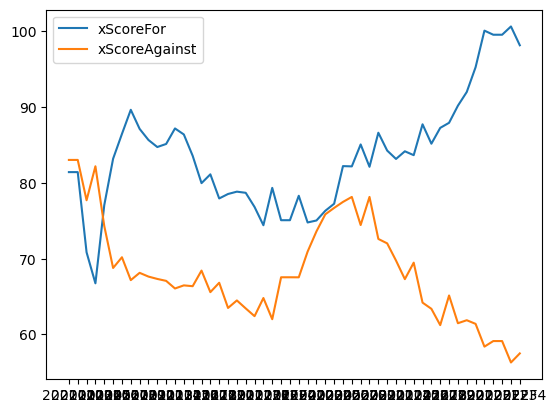

In [147]:
fig = plt.figure()
ax = plt.subplot(111)

ax.plot(x, y_for, label = 'xScoreFor')
ax.plot(x, y_against, label = 'xScoreAgainst')

ax.legend()

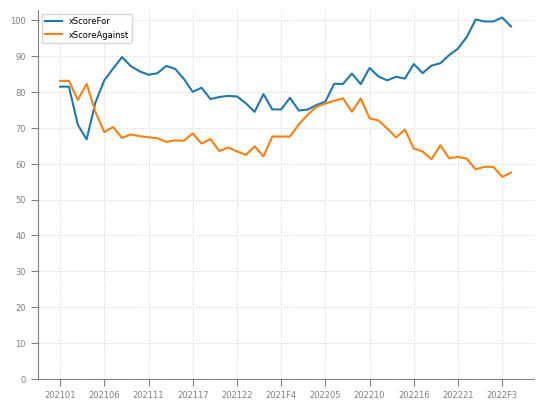

In [148]:
fig = plt.figure()
ax = plt.subplot(111)

ax.spines[['top', 'right']].set_visible(False)
ax.spines[["left", "bottom"]].set_color("grey")

ax.grid(visible=True, lw=0.75, ls=":", color="lightgrey")

ax.plot(x, y_for, label = 'xScoreFor')
ax.plot(x, y_against, label = 'xScoreAgainst')

ax.tick_params(color="grey", length=5, which="major", labelsize=6, labelcolor="grey")
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.set_ylim(0)
ax.legend(fontsize=6)

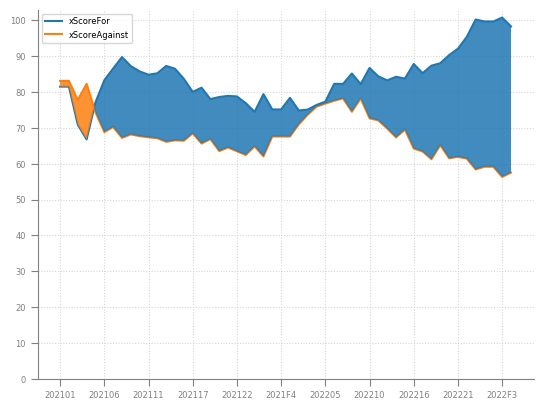

In [149]:
fig = plt.figure()
ax = plt.subplot(111)

ax.spines[['top', 'right']].set_visible(False)
ax.spines[["left", "bottom"]].set_color("grey")

ax.grid(visible=True, lw=0.75, ls=":", color="lightgrey")

ax.plot(x, y_for, label = 'xScoreFor')
ax.plot(x, y_against, label = 'xScoreAgainst')

ax.fill_between(x, y_against, y_for, where = y_for > y_against, interpolate=True, alpha=0.85, zorder=3)
ax.fill_between(x, y_against, y_for, where = y_against >= y_for, interpolate=True, alpha=0.85, zorder=3)

ax.tick_params(color="grey", length=5, which="major", labelsize=6, labelcolor="grey")
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.set_ylim(0)
ax.legend(fontsize=6)

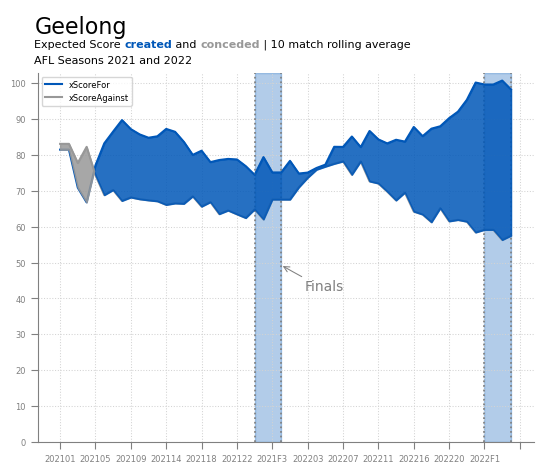

In [150]:
fig = plt.figure()
ax = plt.subplot(111)

ax.spines[['top', 'right']].set_visible(False)
ax.spines[["left", "bottom"]].set_color("grey")

ax.grid(visible=True, lw=0.75, ls=":", color="lightgrey")

line_for = ax.plot(x, y_for, label = 'xScoreFor', color = "#0057B8")
line_against = ax.plot(x, y_against, label = 'xScoreAgainst', color="#989898")
ax.set_ylim(0)
ax.plot([22, 22], [ax.get_ylim()[0], ax.get_ylim()[1]], ls=":", lw=1.25, color="grey", zorder=2)
ax.plot([25, 25], [ax.get_ylim()[0], ax.get_ylim()[1]], ls=":", lw=1.25, color="grey", zorder=2)
plt.axvspan(22, 25, color=line_for[0].get_color(), alpha=0.3)

ax.plot([48, 48], [ax.get_ylim()[0], ax.get_ylim()[1]], ls=":", lw=1.25, color="grey", zorder=2)
ax.plot([51, 51], [ax.get_ylim()[0], ax.get_ylim()[1]], ls=":", lw=1.25, color="grey", zorder=2)
plt.axvspan(48, 51, color=line_for[0].get_color(), alpha=0.3)

ax.annotate(
    xy = (24.5, 50),
    xytext = (20, -20),
    textcoords = "offset points",
    text = "Finals",
    size=10,
    color="grey",
    arrowprops=dict(arrowstyle="->", shrinkA=0, shrinkB=5, color="grey", linewidth=0.75,
                    connectionstyle="angle3,angleA=50,angleB=-30")
)

ax.fill_between(x, y_against, y_for, where = y_for > y_against, interpolate=True, alpha=0.85, zorder=3, color=line_for[0].get_color())
ax.fill_between(x, y_against, y_for, where = y_against >= y_for, interpolate=True, alpha=0.85, zorder=3, color=line_against[0].get_color())

ax.tick_params(color="grey", length=5, which="major", labelsize=6, labelcolor="grey")
ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))

ax.legend(fontsize=6)

fig_text(x = 0.12, y=1,
         s = team,
         color="black",
         size=16,
         annotationbbox_kw={"xycoords":"figure fraction"})

fig_text(x = 0.12, y=0.95,
         s = "Expected Score <created> and <conceded> | 10 match rolling average\nAFL Seasons 2021 and 2022",
         highlight_textprops= [
             {"color":line_for[0].get_color(), "weight":"bold"},
             {"color":line_against[0].get_color(), "weight":"bold"}
         ],
         color="black",
         size=8,
         annotationbbox_kw={"xycoords":"figure fraction"})

In [171]:
def plot_rolling_average(team, data, positive_line, negative_line, color_for = "#0057B8", color_against = "#989898"):
    
    x = data.index
    y_for = data[positive_line]
    y_against = data[negative_line]
    
    fig = plt.figure()
    ax = plt.subplot(111)

    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[["left", "bottom"]].set_color("grey")

    ax.grid(visible=True, lw=0.75, ls=":", color="lightgrey")

    line_for = ax.plot(x, y_for, label = positive_line, color = "#0057B8")
    line_against = ax.plot(x, y_against, label = negative_line, color="#989898")
    ax.set_ylim(0)
    ax.plot([22, 22], [ax.get_ylim()[0], ax.get_ylim()[1]], ls=":", lw=1.25, color="grey", zorder=2)
    ax.plot([25, 25], [ax.get_ylim()[0], ax.get_ylim()[1]], ls=":", lw=1.25, color="grey", zorder=2)
    plt.axvspan(22, 25, color=line_for[0].get_color(), alpha=0.3)

    ax.plot([48, 48], [ax.get_ylim()[0], ax.get_ylim()[1]], ls=":", lw=1.25, color="grey", zorder=2)
    ax.plot([51, 51], [ax.get_ylim()[0], ax.get_ylim()[1]], ls=":", lw=1.25, color="grey", zorder=2)
    plt.axvspan(48, 51, color=line_for[0].get_color(), alpha=0.3)

    ax.annotate(
        xy = (24.5, 50),
        xytext = (20, -20),
        textcoords = "offset points",
        text = "Finals",
        size=10,
        color="grey",
        arrowprops=dict(arrowstyle="->", shrinkA=0, shrinkB=5, color="grey", linewidth=0.75,
                        connectionstyle="angle3,angleA=50,angleB=-30")
    )

    ax.fill_between(x, y_against, y_for, where = y_for > y_against, interpolate=True, alpha=0.85, zorder=3, color=line_for[0].get_color())
    ax.fill_between(x, y_against, y_for, where = y_against >= y_for, interpolate=True, alpha=0.85, zorder=3, color=line_against[0].get_color())

    ax.tick_params(color="grey", length=5, which="major", labelsize=6, labelcolor="grey")
    ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(10))

    ax.legend(fontsize=6)

    fig_text(x = 0.12, y=1,
            s = team,
            color="black",
            size=16,
            annotationbbox_kw={"xycoords":"figure fraction"})

    fig_text(x = 0.12, y=0.95,
            s = "Expected Score <created> and <conceded> | 10 match rolling average\nAFL Seasons 2021 and 2022",
            highlight_textprops= [
                {"color":line_for[0].get_color(), "weight":"bold"},
                {"color":line_against[0].get_color(), "weight":"bold"}
            ],
            color="black",
            size=8,
            annotationbbox_kw={"xycoords":"figure fraction"})
    return fig, ax

(<Figure size 640x480 with 1 Axes>, <Axes: >)

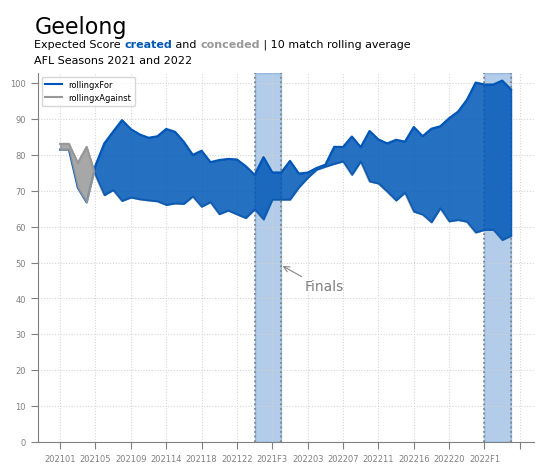

In [172]:
plot_rolling_average(team, df_rolling_exp, positive_line="rollingxFor", negative_line="rollingxAgainst", color_for = "#0057B8", color_against = "#989898")

In [173]:
def get_rolling_plot(team, data, positive_line, negative_line, window=10, color_for="#0057B8", color_against = "#989898"):
    
    df_rolling = get_rolling_data(team=team, window=window, data = data)
    
    fig, ax = plot_rolling_average(team, df_rolling, positive_line, negative_line, color_for = color_for, color_against = color_against)
    
    return fig, ax

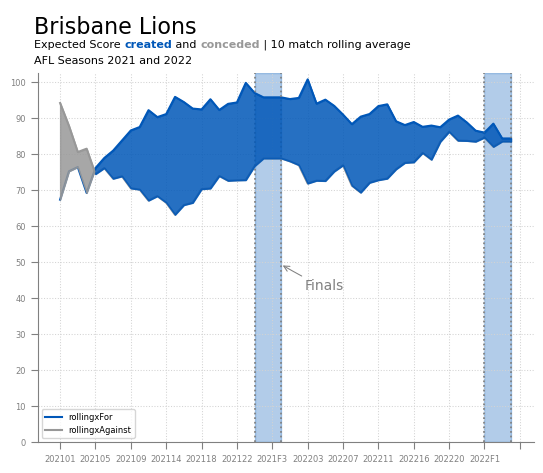

In [175]:
fig, ax = get_rolling_plot(team = "Brisbane Lions", data=df_shots, positive_line = "rollingxFor", negative_line = "rollingxAgainst", window=10, color_for="#0057B8", color_against = "#989898")

Score For v Against

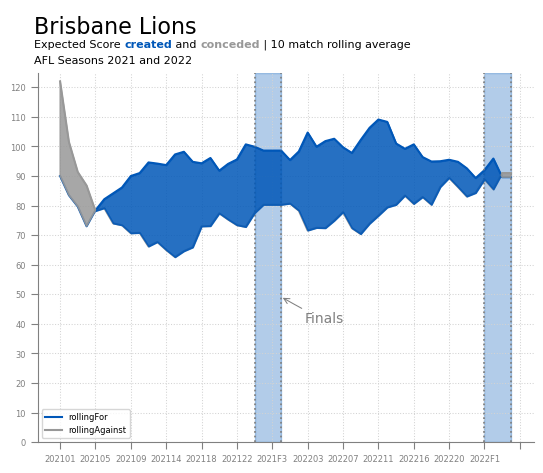

In [176]:
fig, ax = get_rolling_plot(team = "Brisbane Lions", data=df_shots, positive_line = "rollingFor", negative_line = "rollingAgainst", window=10, color_for="#0057B8", color_against = "#989898")

Expected Score Difference v Score Difference

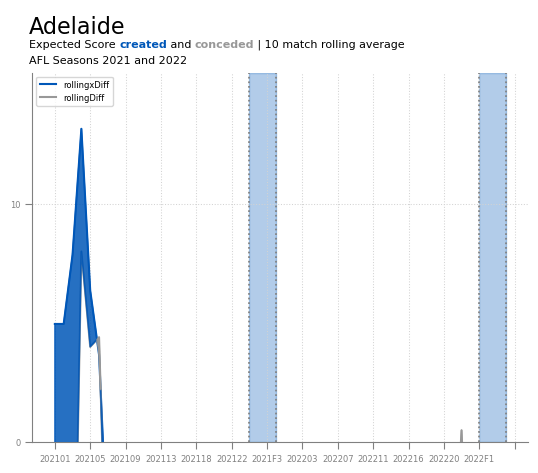

In [178]:
fig, ax = get_rolling_plot(team = "Adelaide", data=df_shots, positive_line = "rollingxDiff", negative_line = "rollingDiff", window=10, color_for="#0057B8", color_against = "#989898")